In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
from scipy.interpolate import CubicSpline
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import AnchoredText
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

import seaborn as sns
font = {'family' : 'sans-serif',
        'size'   : 20}

plt.rc('font', **font)
plt.rc('text',usetex=False)

from pathlib import Path
import os,sys
import h5py, json
import sys 
import pickle as pkl
import time

import nept
sys.path.append('../PreProcessing/')  
sys.path.append('../TrackingAnalyses/')  
sys.path.append('../Lib/')
sys.path.append('../Analyses/')
from filters_ag import *

from importlib import reload  # Python 3.4+ only.
import pre_process_neuralynx as PPN
import TreeMazeFunctions as TMF
import spike_functions as SF
import spatial_tuning as ST
import stats_functions as StatsF
import plot_functions as PF
import zone_analyses_session as ZA

In [6]:
oakPaths = {}
oakPaths['Root'] = Path('/mnt/o/giocomo/alexg/')
oakPaths['Clustered'] = Path('/mnt/o/giocomo/alexg/Clustered/')
oakPaths['PreProcessed'] = Path('/mnt/o/giocomo/alexg/PreProcessed/')
oakPaths['Raw'] = Path('/mnt/o/giocomo/alexg/RawData/InVivo/')
oakPaths['Analyses'] = Path('/mnt/o/giocomo/alexg/Analyses')

In [10]:
animal = 'Li'
task = 'T3g'
date = '062718'
session = animal+'_'+task+'_'+date

In [12]:
sessionPaths = ZA.getSessionPaths(oakPaths,session)
PosDat = TMF.getBehTrackData(sessionPaths,0)
cell_bin_spikes, mua_bin_spikes, ids= SF.getSessionBinSpikes(sessionPaths,PosDat['t'])
cell_FR, mua_FR = SF.getSessionFR(sessionPaths)

Loading Beh Tracking Data
Complete.
Loading Spikes...
Binned Spike Files Loaded.
Loading FRs ...
FR Loaded.


In [17]:
def plot_eFR(res,step,selected_params):
    estimatedBaseRate = np.exp(res.params[0])/step
    ci=(np.exp(res.conf_int()[1::])-1)*estimatedBaseRate
    estimatedFRs = (np.exp(res.params[1::])-1)*estimatedBaseRate
    nParams=len(res.params)-1
    x=np.tile(np.arange(nParams),[2,1])
    #sns.barplot(x=np.arange(57),y=np.exp(res.params)-1,ci=np.exp(res.conf_int()-1),capsize=.2)
    
    f,a=plt.subplots(1,1, figsize=(14,5))
    ab=sns.barplot(x=np.arange(nParams),y=estimatedFRs,ax=a, 
                   facecolor=(0.5, 0.5, 0.5, 1))
    for p in np.arange(nParams):
        a.plot(x[:,p],ci.iloc[p],color='k',linewidth=3)
    a.set_ylabel('FR[sp/s]')
    a.set_xticklabels(selected_params)
    #a.grid()
    sns.set_style("whitegrid")
    sns.despine(left=True)
    for tick in a.get_xticklabels():
        tick.set_rotation(45)
    return f,a
        

In [78]:
def PDeviance(y,mu):
    y = y+1e-10
    mu = mu+1e-10
    return 2*np.sum(y*np.log(y/mu)-(y-mu))

In [154]:
def plotFitComp(orig,fit,spks,time,a):    
    a.plot(time,orig,color='k',alpha=0.7)
    a.plot(time,fit,color='r',alpha=1)
    a.plot(time,spks,'k',alpha=0.5)
    a.set_ylabel('FR[sp/s]')
    a.set_xlabel('Time[s]')
    a.set_ylim([0,a.get_ylim()[1]])
    return a

In [30]:
io=pd.DataFrame(np.array((PosDat['InSeg'],PosDat['OutSeg'])).T.astype(int),columns=['In','Out'])
FullMat=pd.concat([PosDat['PosMat'],PosDat['EventDat'],io],axis=1)
FullMat.head()

,Home,SegA,Center,SegB,I1,SegC,G1,SegD,G2,SegE,...,L4,CL,CR,TrID,cTr,iTr,LDs,RDs,In,Out
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
pos_params = ['SegA','Center','SegB','I1','SegC','G1','SegD',
              'G2','SegE','I2','SegF','G3','SegG','G4']
reward_params = ['RH','RC','R1','R2','R3','R4']
dir_params = ['In','Out']
cue_params = ['CL','CR']
params = {'p':pos_params,'r':reward_params,'d':dir_params,'c':cue_params}
lst = 'prdc'
combs = []

for i in np.arange(1, len(lst)+1):
    combs+= [list(x) for x in itertools.combinations(lst, i)]

models = {}
nParams = {}
for c in combs:
    mod = ''
    for e in c:
        mod+=e
    models[mod]=[]
    for e in c:
        models[mod]+= params[e]
    nParams[mod]=len(models[mod])
nModels = len(models)
models

{'p': ['SegA',
  'Center',
  'SegB',
  'I1',
  'SegC',
  'G1',
  'SegD',
  'G2',
  'SegE',
  'I2',
  'SegF',
  'G3',
  'SegG',
  'G4'],
 'r': ['RH', 'RC', 'R1', 'R2', 'R3', 'R4'],
 'd': ['In', 'Out'],
 'c': ['CL', 'CR'],
 'pr': ['SegA',
  'Center',
  'SegB',
  'I1',
  'SegC',
  'G1',
  'SegD',
  'G2',
  'SegE',
  'I2',
  'SegF',
  'G3',
  'SegG',
  'G4',
  'RH',
  'RC',
  'R1',
  'R2',
  'R3',
  'R4'],
 'pd': ['SegA',
  'Center',
  'SegB',
  'I1',
  'SegC',
  'G1',
  'SegD',
  'G2',
  'SegE',
  'I2',
  'SegF',
  'G3',
  'SegG',
  'G4',
  'In',
  'Out'],
 'pc': ['SegA',
  'Center',
  'SegB',
  'I1',
  'SegC',
  'G1',
  'SegD',
  'G2',
  'SegE',
  'I2',
  'SegF',
  'G3',
  'SegG',
  'G4',
  'CL',
  'CR'],
 'rd': ['RH', 'RC', 'R1', 'R2', 'R3', 'R4', 'In', 'Out'],
 'rc': ['RH', 'RC', 'R1', 'R2', 'R3', 'R4', 'CL', 'CR'],
 'dc': ['In', 'Out', 'CL', 'CR'],
 'prd': ['SegA',
  'Center',
  'SegB',
  'I1',
  'SegC',
  'G1',
  'SegD',
  'G2',
  'SegE',
  'I2',
  'SegF',
  'G3',
  'SegG',
  'G4',
 

In [178]:
GLMRes = {'FitResults': {'Cells':{},'Mua':{}},
          'SelectedModel':{'Cells':[],'Mua':[]},
          'CoefficientsSM':{'Cells':{},'Mua':{}},
          'models':models, 'nParams':nParams}

fitMeasures = ['Train_PR2','Test_PR2','R2','AIC','BIC','LLF']
modelNames = list(models.keys())
nCells = len(ids['cells'])
nMua = len(ids['muas'])

Res = pd.DataFrame(np.zeros((nCells,nModels)),columns=modelNames)
for me in fitMeasures:
    GLMRes['FitResults']['Cells'][me]= pd.DataFrame(np.zeros((nCells,nModels)),columns=modelNames)
    GLMRes['FitResults']['Mua'][me]= pd.DataFrame(np.zeros((nMua,nModels)),columns=modelNames)


for mod,params in models.items():
    #selected_params = pos_params+reward_params+cue_params+dir_params
    M = sm.add_constant(FullMat[params])

    for ut in ['Cells','Mua']:
        if ut=='Cells':
            nUnits = nCells
            Spikes = cell_bin_spikes
            FR = cell_FR
        else:
            nUnits = nMua 
            Spikes = mua_bin_spikes
            FR = mua_FR
       
        y=Spikes[0,:]
        xTrain, xTest, yTrain, yTest = train_test_split(M,y, test_size = 0.5, random_state = 0,shuffle=False)
        time_test = PosDat['t'][xTest.index]
        #window_test=np.where(np.logical_and(time_test>=minMark,time_test<(minMark+60)))[0]

        glm_train_fits = {}

        for c in np.arange(nUnits):
            try:
                y=Spikes[c,:]
                fr=FR[c,:]
                if c>0:
                    _, _, yTrain, yTest = train_test_split(M,y, test_size = 0.5, random_state = 0,shuffle=False)
                glm_train = sm.GLM(yTrain,xTrain,family = sm.families.Poisson())
                glm_train_fits[c] = glm_train.fit()
                glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
                glm_null_fit = glm_null.fit()
                glm_train_fits[c] = glm_train.fit()

                PR2_Train = 1-glm_train_fits[c].deviance/glm_null_fit.deviance
                muTest =glm_train_fits[c].predict(xTest)
                TestDev = PDeviance(yTest,muTest)
                muNullTest = glm_null_fit.predict(xTest['const'])
                TestNullDev = PDeviance(yTest,muNullTest)
                PR2_Test = 1-TestDev/TestNullDev 

                smPredSp = SF.smoothSpikesTrain(muTest)
                R2_Test = np.corrcoef(fr[xTest.index],smPredSp)[0,1]**2
                GLMRes['FitResults'][ut]['AIC'][mod].iloc[c] = glm_train_fits[c].aic
                GLMRes['FitResults'][ut]['BIC'][mod].iloc[c] = glm_train_fits[c].bic
                GLMRes['FitResults'][ut]['LLF'][mod].iloc[c] = glm_train_fits[c].llf
                GLMRes['FitResults'][ut]['R2'][mod].iloc[c] = R2_Test
                GLMRes['FitResults'][ut]['Test_PR2'][mod].iloc[c] = PR2_Test
                GLMRes['FitResults'][ut]['Train_PR2'][mod].iloc[c] = PR2_Train
            except:
                print("Error Processing Mod {}, {} ID {}".format(mod,ut,c))
                pass
            


Error Processing Mod pd, Mua ID 12
Error Processing Mod prd, Mua ID 12


In [173]:
ut='Cells'
if ut=='Cells':
    nUnits = nCells
else:
    nUnits = nMua
maxR2Model = GLMRes['FitResults'][ut]['R2'].T.idxmax()
selModel =GLMRes['FitResults'][ut]['BIC'].T.idxmin()
MS=pd.DataFrame(np.zeros((nUnits,5)),columns=['maxModR2','maxR2','bicMod','bicModR2','bic/max'])
MS['maxModR2'] = GLMRes['FitResults'][ut]['R2'].T.idxmax()
MS['maxR2'] = GLMRes['FitResults'][ut]['R2'].T.max()
MS['bicMod'] = GLMRes['FitResults'][ut]['BIC'].T.idxmin()

for c in np.arange(nUnits):
     MS['bicModR2'].iloc[c]=GLMRes['FitResults'][ut]['R2'][selModel[c]][c]
    
MS['bic/max'] = MS['bicModR2']/MS['maxR2']

In [192]:
pd.options.display.float_format = '{:.3f}'.format
MS

,maxModR2,maxR2,bicMod,bicModR2,bic/max
0,rc,0.006,d,0.000,0.000
1,pr,0.051,c,0.010,0.196
2,prdc,0.150,pd,0.137,0.916
3,prdc,0.397,prd,0.388,0.979
4,pd,0.002,d,0.000,0.041
5,pr,0.312,pd,0.303,0.972
6,prd,0.316,pd,0.305,0.965
7,p,0.113,d,0.108,0.955
8,prd,0.265,pd,0.242,0.915
9,rd,0.139,d,0.128,0.919


In [200]:

MS=pd.DataFrame(np.zeros((nCells+nMua,5)),columns=['maxModR2','maxR2','bicMod','bicModR2','bic/max'])

for ut in ['Cells','Mua']:
    if ut=='Cells':
        nUnits = nCells
        uIDs = np.arange(nCells)
    else:
        nUnits = nMua
        uIDs = np.arange(nMua)+nCells
        
    maxR2Model = GLMRes['FitResults'][ut]['R2'].T.idxmax()
    selModel =GLMRes['FitResults'][ut]['BIC'].T.idxmin()
    MS['maxModR2'][uIDs] = GLMRes['FitResults'][ut]['R2'].T.idxmax()
    MS['maxR2'][uIDs]  = GLMRes['FitResults'][ut]['R2'].T.max()
    MS['bicMod'][uIDs]  = GLMRes['FitResults'][ut]['BIC'].T.idxmin()

    for c in np.arange(nUnits):
         MS['bicModR2'][uIDs[c]]=GLMRes['FitResults'][ut]['R2'][selModel[c]][c]
    
MS['bic/max'] = MS['bicModR2']/MS['maxR2']
print(MS)

/home/alexg8/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/alexg8/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/alexg8/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alexg8/anaconda3/lib/python3.7/site-packages/ipykern

   maxModR2  maxR2 bicMod  bicModR2  bic/max
0        rc  0.006      d     0.000    0.000
1        pr  0.051      c     0.010    0.196
2      prdc  0.150     pd     0.137    0.916
3      prdc  0.397    prd     0.388    0.979
4        pd  0.002      d     0.000    0.041
5        pr  0.312     pd     0.303    0.972
6       prd  0.316     pd     0.305    0.965
7         p  0.113      d     0.108    0.955
8       prd  0.265     pd     0.242    0.915
9        rd  0.139      d     0.128    0.919
10     prdc  0.401    prd     0.397    0.991
11     prdc  0.396      p     0.388    0.981
12        r  0.017     rd     0.005    0.290
13      prd  0.363     pd     0.360    0.992
14     prdc  0.429   prdc     0.429    1.000
15      prd  0.378    prc     0.375    0.992
16        c  0.001      d     0.000    0.075
17      prc  0.264      p     0.259    0.981
18     prdc  0.321    pdc     0.309    0.963
19        d  0.001      c     0.000    0.118
20      prd  0.261    prc     0.229    0.878
21     prd

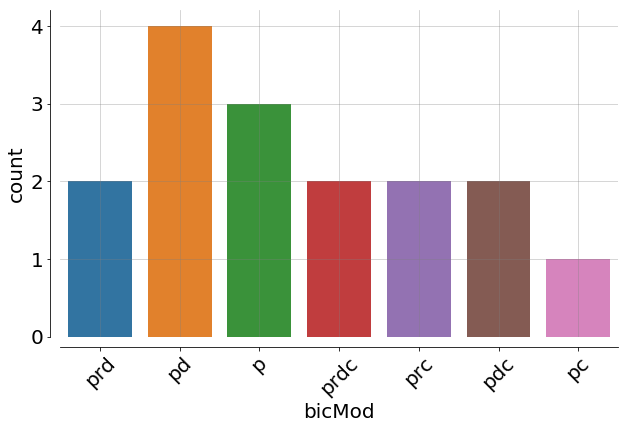

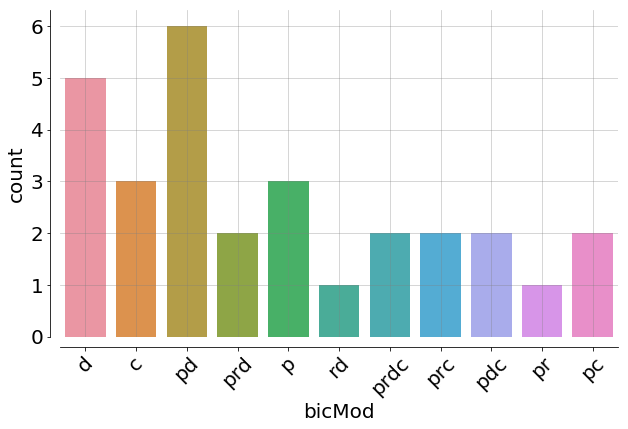

In [214]:
f,ax = plt.subplots(figsize=(10,6))
sns.axes_style('whitegrid')
ax=sns.countplot(MS['bicMod'][MS['bicModR2']>0.2])

#ax.grid()
sns.despine(offset=10, trim=False,ax=ax)
ax.grid(axis='both',color='grey',alpha=0.4)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

f,ax = plt.subplots(figsize=(10,6))
sns.axes_style('whitegrid')
ax=sns.countplot(MS['bicMod'])

#ax.grid()
sns.despine(offset=10, trim=False,ax=ax)
ax.grid(axis='both',color='grey',alpha=0.4)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)



In [213]:
np.mean(MS['bicModR2']>0.25)

0.4827586206896552

In [198]:
MS['maxModR2'][np.arange(10)+2]

2     prdc
3     prdc
4       pd
5       pr
6      prd
7        p
8      prd
9       rd
10    prdc
11    prdc
Name: maxModR2, dtype: object

In [56]:
for cell in [9]:#np.arange(nCells):
    
    y=cell_sp[cell,:]
    if cell>0:
        _, _, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)

    glm_train = sm.GLM(yTrain,xTrain,family = sm.families.Poisson())
    glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
    glm_null_fit = glm_null.fit()
    glm_train_fits[cell] = glm_train.fit()

    PR2_Train[cell] = 1-glm_train_fits[cell].deviance/glm_null_fit.deviance
    muTest =glm_train_fits[cell].predict(xTest)
    TestDev = PDeviance(yTest,muTest)
    muNullTest = glm_null_fit.predict(xTest['const'])
    TestNullDev = PDeviance(yTest,muNullTest)
    PR2_Test[cell] = 1-TestDev/TestNullDev 
    
    f,a= plot_eFR(glm_train_fits[cell],step,selected_params)
    a.set_title('Cell_ID={0}, Train_PR2={1:0.2f}, Test_PR2={2:0.2f}'.format(cell,PR2_Train[cell],PR2_Test[cell]))
    f.savefig('/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots/GLM_Fits_Cell_{}.pdf'.format(cell),
              bbox_inches='tight',pad_inches=0.2)
    if not pltshow:
        plt.close(f)

    lfwin = np.round(1.0/step).astype(int)
    sm_yTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,yTest)/step
    sm_muTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,muTest.as_matrix())/step

    R2_Test[cell] = np.corrcoef(sm_yTest,sm_muTest)[0,1]**2
    
    
    f,(a1,a2)=plt.subplots(2,1, figsize=(12,10))
    a1.set_position([0.125, 0.38, 0.775, 0.53])
    a1=plotBehWindow(time_test[window_test],xTest.iloc[window_test].T,xTest.columns,a1)
    a1.set_xticks([])    
    a1.set_title('Cell_ID={0}, OoS_R2={1:0.2f}'.format(cell,R2_Test[cell]))

    a2.set_position([0.125, 0.2, 0.775, 0.15])
    a2=plotFitComp(sm_yTest[window_test],sm_muTest[window_test],
                   yTest[window_test]>0,time_test[window_test],a2 )
    a2.set_xlim(time_test[window_test][0],time_test[window_test][-1])
    f.savefig('/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots/GLM_FR_Plot_Cell_{}.png'.format(cell),
              dpi=500,bbox_inches='tight',pad_inches=0.2)  
    if not pltshow:
        plt.close(f)

16

In [342]:
def plot_eFR2(res,baseRate,step,selected_params):
    ci=(np.exp(res.conf_int())-baseRate)/step
    estimatedFRs = (np.exp(res.params)-baseRate)/step
    nParams=len(res.params)
    x=np.tile(np.arange(nParams),[2,1])
    #sns.barplot(x=np.arange(57),y=np.exp(res.params)-1,ci=np.exp(res.conf_int()-1),capsize=.2)
    
    f,a=plt.subplots(1,1, figsize=(14,5))
    ab=sns.barplot(x=np.arange(nParams),y=estimatedFRs,ax=a, 
                   facecolor=(0.5, 0.5, 0.5, 1))
    for p in np.arange(nParams):
        a.plot(x[:,p],ci.iloc[p],color='k',linewidth=3)
    a.set_ylabel('FR[sp/s]')
    a.set_xticklabels(selected_params)
    #a.grid()
    sns.set_style("whitegrid")
    sns.despine(left=True)
    for tick in a.get_xticklabels():
        tick.set_rotation(45)
    return f,a

In [491]:
def plot_params(params,ci,selected_params):

    nParams=len(params)
    x=np.tile(np.arange(nParams),[2,1])
    
    f,a=plt.subplots(1,1, figsize=(14,5))
    ab=sns.barplot(x=np.arange(nParams),y=params,ax=a, 
                   facecolor=(0.5, 0.5, 0.5, 1))
    for p in np.arange(nParams):
        a.plot(x[:,p],ci.iloc[p],color='k',linewidth=3)
        
    a.set_ylabel('PE [au]')
    a.set_xticklabels(selected_params)
    #a.grid()
    sns.set_style("whitegrid")
    sns.despine(left=True)
    for tick in a.get_xticklabels():
        tick.set_rotation(45)
    return f,a

In [500]:
model = 'Complete'

pos_params = ['Home','SegA','Center','SegB','I1','SegC','G1','SegD',
              'G2','SegE','I2','SegF','G3','SegG','G4']

reward_params = ['RH','RC','R1','R2','R3','R4']
cue_params = ['CL','CR']
dir_params = TMF.SegDirNames
goal_params = ['Home','Center','G1','G2','G3','G4']

sp = '/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots'

PlotDir = Path(sp,model)
PlotDir.mkdir(parents=True, exist_ok=True)

FullMat=pd.concat([PosDat['PosMat'],PosDat['SegDirMat'],EventMat],axis=1)

if model=='Complete':
    selected_params = pos_params + reward_params + cue_params
    M2 = sm.add_constant(FullMat[selected_params])
elif model=='Rewards':
    selected_params = reward_params
    M2 = sm.add_constant(FullMat[reward_params])
elif model=='Cues':
    selected_params = cue_params
    M2 = sm.add_constant(FullMat[reward_params])

y=cell_sp[0,:]
xTrain, xTest, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)
time_test = t[xTest.index]
window_test=np.where(np.logical_and(time_test>=minMark,time_test<(minMark+60)))[0]
    
glm_train_fits = {}
PR2_Train = np.zeros(nCells)
PR2_Test = np.zeros(nCells)
R2_Test = np.zeros(nCells)
TrainBaseRate = np.zeros(nCells)
nParams = len(selected_params)
ZVals = pd.DataFrame(np.zeros((nCells,nParams)),columns=selected_params)
ParamsEst = pd.DataFrame(np.zeros((nCells,nParams)),columns=selected_params)
PVals = pd.DataFrame(np.zeros((nCells,nParams)),columns=selected_params)
plotFlag = 1
pltshow = 0
if not pltshow:
    plt.ioff()
    
for cell in np.arange(nCells):
    
    y=cell_sp[cell,:]
    if cell>0:
        _, _, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)

    TrainBaseRate[cell] = np.mean(yTrain)
    
    # train model and firt to test set
    if model=='Complete':
        glm_train = sm.GLM(yTrain,xTrain.drop(['const'],axis=1),family = sm.families.Poisson())
        glm_train_fits[cell] = glm_train.fit()
        muTest =glm_train_fits[cell].predict(xTest.drop(['const'],axis=1))
    else:
        glm_train = sm.GLM(yTrain,xTrain,family = sm.families.Poisson())
        glm_train_fits[cell] = glm_train.fit()
        muTest =glm_train_fits[cell].predict(xTest)
        
    
    # get null / constant model fits
    glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
    glm_null_fit = glm_null.fit()
    muNullTest = glm_null_fit.predict(xTest['const'])
   
    # get performance metrics
    PR2_Train[cell] = 1-glm_train_fits[cell].deviance/glm_null_fit.deviance
    TestDev = PDeviance(yTest,muTest)
    TestNullDev = PDeviance(yTest,muNullTest)
    PR2_Test[cell] = 1-TestDev/TestNullDev 
    
    # Store parameters
    ZVals.iloc[cell] = glm_train_fits[cell].tvalues
    ParamsEst.iloc[cell] = np.exp(glm_train_fits[cell].params)
    PVals.iloc[cell]=glm_train_fits[cell].pvalues

    # smooth binned spikes to obtain FRs
    lfwin = np.round(0.5/step).astype(int)
    sm_yTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,yTest)/step
    sm_muTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,muTest.as_matrix())/step

    R2_Test[cell] = np.corrcoef(sm_yTest,sm_muTest)[0,1]**2
    
    # plot results
    if plotFlag:
        f,a= plot_params(glm_train_fits[cell].params,glm_train_fits[cell].conf_int(),selected_params)
        a.set_title('Cell_ID={0}, Train_PR2={1:0.2f}, Test_PR2={2:0.2f}'.format(cell,PR2_Train[cell],PR2_Test[cell]))
        f.savefig(('{}/{}_GLM_Fits_RawParams_Cell_{}.pdf').format(sp,model,cell),bbox_inches='tight',pad_inches=0.2)
        if not pltshow:
            plt.close(f)
        
        f,a= plot_eFR2(glm_train_fits[cell],TrainBaseRate[cell],step,selected_params)
        a.set_title('Cell_ID={0}, Train_PR2={1:0.2f}, Test_PR2={2:0.2f}'.format(cell,PR2_Train[cell],PR2_Test[cell]))
        f.savefig(('{}/{}_GLM_Fits_eFRs_Cell_{}.pdf').format(sp,model,cell),bbox_inches='tight',pad_inches=0.2)
        if not pltshow:
            plt.close(f)
        
        f,(a1,a2)=plt.subplots(2,1, figsize=(12,10))
        a1.set_position([0.125, 0.38, 0.775, 0.53])
        a1=plotBehWindow(time_test[window_test],xTest.iloc[window_test].T,xTest.columns,a1)
        a1.set_xticks([])    
        a1.set_title('Cell_ID={0}, OoS_R2={1:0.2f}'.format(cell,R2_Test[cell]))

        a2.set_position([0.125, 0.2, 0.775, 0.15])
        a2=plotFitComp(sm_yTest[window_test],sm_muTest[window_test],
                       yTest[window_test]>0,time_test[window_test],a2 )
        a2.set_xlim(time_test[window_test][0],time_test[window_test][-1])
        f.savefig(('{}/{}_GLM_TestWindow_Cell_{}.png').format(sp,model,cell),dpi=500,bbox_inches='tight',pad_inches=0.2)

        if not pltshow:
            plt.close(f)

False

In [465]:
cell=14
y=cell_sp[cell,:]
_, _, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)
glm_train = sm.GLM(yTrain,xTrain.drop(['const'],axis=1),family = sm.families.Poisson())
glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
glm_null_fit = glm_null.fit()
glm_train_fits[cell] = glm_train.fit()


In [482]:
pa='Center'
np.mean(yTrain[xTrain[pa]])/step,ParamsEst[pa].loc[cell]/step


(41.20304540110843, 11.759082376029667)

In [350]:
np.exp(glm_train_fits[cell].params['Home'])

10.86690070351715

In [487]:
#X=(np.ParamsEst[reward_params]-np.tile(TrainBaseRate,[len(reward_params),1]).T>0)*(PVals[reward_params]*nParams*nCells<0.001)

X=np.log(ParamsEst[reward_params])
X

,RH,RC,R1,R2,R3,R4
0,-0.145369,-0.071356,-0.251186,0.084414,-0.155944,-0.161971
1,-0.273723,0.082610,-0.087069,0.063380,-0.075489,-0.143872
2,-0.238234,-0.028081,-0.192796,-0.140183,-0.221809,-0.211014
3,-0.349746,-0.303213,-0.316235,0.003384,-0.144198,-0.153547
4,-0.086459,0.024052,-0.012363,0.104985,-0.101691,-0.035850
5,-0.131548,-2.341411,1.003434,-3.139073,0.135233,-0.711476
6,-0.405218,-0.342229,-0.127765,-0.294339,-0.393689,0.105613
7,-0.213623,-0.141371,-0.020254,-0.424119,-0.227082,-0.050577
8,-1.464796,-0.297631,-1.468727,0.400991,-1.033215,-0.645258
9,-0.340246,-0.100228,0.303637,0.307330,-0.954118,-0.892103


In [451]:
ZVals[reward_params].loc[14]

RH   -1.858327
RC   -7.645602
R1   -2.643148
R2   -2.817244
R3   -5.176846
R4   -3.649426
Name: 14, dtype: float64

Home      21.654222
SegA       9.236695
Center    -3.598920
SegB       8.897570
I1         5.604045
SegC       2.538475
G1        -5.041505
SegD       6.656821
G2        -9.029404
SegE       1.538201
I2         6.617961
SegF       1.846251
G3        -8.476314
SegG       8.796445
G4        -0.467933
RH        32.189901
RC        14.020176
R1        20.154315
R2        18.046659
R3         6.178264
R4        20.478647
CL        15.781963
CR        12.592349
dtype: float64

In [357]:
(ParamsEst[['CL','CR']].as_matrix()>0)*(PVals[['CL','CR']]*nParams*nCells<0.001).as_matrix()

array([[False, False],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True, False],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False]])

In [392]:
pa = 'Center'
((ParamsEst[pa]-TrainBaseRate)>0)*(PVals[pa]<0.001)*R2_Test>0.3

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15     True
16    False
17    False
18    False
19     True
20    False
Name: Center, dtype: bool

In [409]:
np.sqrt(R2_Test)[R2_Test>0.5]

array([0.79096877])

In [414]:
200

4.315789473684211

In [936]:
#selected_params = ['Home','SegA','Center','SegB','I1','SegC','G1','SegD',
#                   'G2','SegE','I2','SegF','G3','SegG','G4','RH','RC','R1','R2','R3','R4','CL','CR']
selected_params = ['SegA','Center','SegB','I1','SegC','G1','SegD',
                   'G2','SegE','I2','SegF','G3','SegG','G4','RH','RC','R1','R2','R3','R4','CL','CR']

pos_params = ['SegA','Center','SegB','I1','SegC','G1','SegD',
              'G2','SegE','I2','SegF','G3','SegG','G4']

reward_params = ['RH','RC','R1','R2','R3','R4']
cue_params = ['CL','CR']
dir_params = TMF.SegDirNames
goal_params = ['Home','Center','G1','G2','G3','G4']

FullMat=pd.concat([PosDat['PosMat'],PosDat['SegDirMat'],EventMat],axis=1)

#selected_params =goal_params+dir_params+reward_params+cue_params
selected_params =pos_params+reward_params+cue_params
#selected_params = pos_params+reward_params+cue_params+dir_params
M2 = sm.add_constant(FullMat[selected_params])

y=cell_sp[0,:]
xTrain, xTest, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)

In [185]:
RewardMat = EventMat[reward_params]

detect_params = ['DH','DC','D1','D2','D3','D4']
DetecMat = EventMat[detect_params] 
reLength = 1/step # one second
deLength = 1.5*1/step # two secs

for r in reward_params:
    RewardMat[r] = (signal.lfilter(np.arange(reLength),1,RewardMat[r])>0).astype(int)
    
for d in detect_params:
    DetecMat[d] = (signal.lfilter(np.arange(deLength),1,DetecMat[d])>0).astype(int)
    
cnt = 0


In [187]:
ReDeMat=pd.concat([DetecMat,RewardMat],axis=1)
selected_params = detect_params+reward_params
M2 = sm.add_constant(ReDeMat)

y=cell_sp[0,:]
xTrain, xTest, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)
time_test = t[xTest.index]
window_test=np.where(np.logical_and(time_test>=minMark,time_test<(minMark+60)))[0]
    
glm_train_fits = {}
PR2_Train = np.zeros(nCells)
PR2_Test = np.zeros(nCells)
R2_Test = np.zeros(nCells)
# Turn interactive plotting off
plt.ioff()
for cell in np.arange(nCells):
    
    if cell>0:
        y=cell_sp[cell,:]
        _, _, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)

    glm_train = sm.GLM(yTrain,xTrain,family = sm.families.Poisson())
    glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
    glm_null_fit = glm_null.fit()
    glm_train_fits[cell] = glm_train.fit()

    PR2_Train[cell] = 1-glm_train_fits[cell].deviance/glm_null_fit.deviance
    muTest =glm_train_fits[cell].predict(xTest)
    TestDev = PDeviance(yTest,muTest)
    muNullTest = glm_null_fit.predict(xTest['const'])
    TestNullDev = PDeviance(yTest,muNullTest)
    PR2_Test[cell] = 1-TestDev/TestNullDev 
    
    f,a= plot_eFR(glm_train_fits[cell],step,selected_params)
    a.set_title('Cell_ID={0}, Train_PR2={1:0.2f}, Test_PR2={2:0.2f}'.format(cell,PR2_Train[cell],PR2_Test[cell]))
    f.savefig('/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots/GLM_FitsReDe_Cell_{}.pdf'.format(cell),
              bbox_inches='tight',pad_inches=0.2)    
    plt.close(f)

    lfwin = np.round(1.0/step).astype(int)
    sm_yTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,yTest)/step
    sm_muTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,muTest.as_matrix())/step

    R2_Test[cell] = np.corrcoef(sm_yTest,sm_muTest)[0,1]**2
     
    f,(a1,a2)=plt.subplots(2,1, figsize=(12,10))
    a1.set_position([0.125, 0.38, 0.775, 0.53])
    a1=plotBehWindow(time_test[window_test],xTest.iloc[window_test].T,xTest.columns,a1)
    for tick in a1.get_yticklabels():
        tick.set_rotation(0)
    
    a1.set_xticks([])    
    a1.set_title('Cell_ID={0}, OoS_R2={1:0.2f}'.format(cell,R2_Test[cell]))

    a2.set_position([0.125, 0.2, 0.775, 0.15])
    a2=plotFitComp(sm_yTest[window_test],sm_muTest[window_test],
                   yTest[window_test]>0,time_test[window_test],a2 )
    a2.set_xlim(time_test[window_test][0],time_test[window_test][-1])
    f.savefig('/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots/GLM_FR_ReDe_Plot_Cell_{}.png'.format(cell),
              dpi=500,bbox_inches='tight',pad_inches=0.2)  
    plt.close(f)
plt.show()

In [182]:
M2

,const,DH,DC,D1,D2,D3,D4,RH,RC,R1,R2,R3,R4
0,1.0,False,False,False,False,False,False,False,False,False,False,False,False
1,1.0,False,False,False,False,False,False,False,False,False,False,False,False
2,1.0,False,False,False,False,False,False,False,False,False,False,False,False
3,1.0,False,False,False,False,False,False,False,False,False,False,False,False
4,1.0,False,False,False,False,False,False,False,False,False,False,False,False
5,1.0,False,False,False,False,False,False,False,False,False,False,False,False
6,1.0,False,False,False,False,False,False,False,False,False,False,False,False
7,1.0,False,False,False,False,False,False,False,False,False,False,False,False
8,1.0,False,False,False,False,False,False,False,False,False,False,False,False
9,1.0,False,False,False,False,False,False,False,False,False,False,False,False
